# [k-근접이웃 실습: 실전]

##### jupyter notebook 단축키

- ctrl+enter: 셀 실행   
- shift+enter: 셀 실행 및 다음 셀 이동   
- alt+enter: 셀 실행, 다음 셀 이동, 새로운 셀 생성
- a: 상단에 새로운 셀 만들기
- b: 하단에 새로운 셀 만들기
- dd: 셀 삭제(x: 셀 삭제)
- 함수 ( ) 안에서 shift+tab: arguments description. shift+tab+tab은 길게 볼 수 있도록

## 1. 모듈 불러오기

import 불러올 패키지명 as 그 패키지를 파이썬에서 사용할 이름

In [1]:
# 데이터 전처리
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

# 기계학습 모델 생성, 학습, 평가
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import VALID_METRICS
from sklearn.metrics import SCORERS

# 시각화
import seaborn as sns
import matplotlib.pyplot as plt

## 2. p2p 대출 데이터
#### 문제상황
- P2P 대출이란 일종의 크라우드펀딩으로 온라인 플랫폼을 기반으로 개인끼리 자금을 빌려주고 돌려받는 새로운 개념의 대출형태. 플랫폼이 온라인이라는 특수성 때문에 투자자들은 온라인에서 차용인의 정보만 획득하고 투자를 결정 <br>
- 기존 신용평가모형이 아닌 새로운 대출지표가 필요. 머신러닝 방법론을 기반으로 금융·비금융 정보를 활용한 대출 상환예측 모델을 구축
<br>
<br>

#### 설명변수 및 반응변수
- annual_inc - 연봉
- bc_util - 모든 카드의 신용금액 대비 현재 잔액 비율
- dti - 총 부채상환 비율
- num_accts_ever_120_pd - 120일 이상 연체한 계좌 수
- pub_rec_bankruptcies - 부정적인 공공정보의 수
- tax_liens - 세금에 의한 재산 차압의 수
- tot_hi_cred_lim - 전체 신용한도
- total_bc_limit - 신용카드의 한도
- avg_cur_bal - 계좌의 평균 잔액
- pct_tl_nvr_dlq - 연체 없는 거래의 비율
- total_acc - 전체 한도 계좌의 수
- int_rate - 이자
- home_ownership - 집 소유 상태 (3종류: Own, Rent, Mortgage) <span style="color:red"> (범주형) </span>
- term - 상환기간 <span style="color:red"> (범주형) </span>
- <span style="color:blue">TARGET - 0: 상환 성공, 1: 상환 실패 <b>[타겟 변수]</b> <br></span>

In [2]:
data = pd.read_csv('../Data/p2p.csv')
data.head()

,annual_inc,bc_util,dti,num_accts_ever_120_pd,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bc_limit,avg_cur_bal,pct_tl_nvr_dlq,total_acc,int_rate,home_ownership,term,TARGET
0,53000.0,88.8,25.25,0,0,0,132074,11200,14564,100.0,17,20.49,OWN,60 months,1
1,60000.0,94.4,25.88,1,0,0,68761,6300,5565,87.5,16,12.29,RENT,36 months,0
2,125000.0,82.5,10.93,0,0,0,229006,15000,14929,100.0,41,7.89,RENT,36 months,0
3,90000.0,77.6,22.75,0,0,0,248018,43900,12054,100.0,41,17.57,MORTGAGE,60 months,0
4,76863.0,43.3,19.53,2,0,0,40792,2400,3816,77.8,20,9.17,MORTGAGE,36 months,0


### 범주형 변수에 대한 더미 변수 생성

In [3]:
# date: dummies
data = pd.get_dummies(data, columns=['home_ownership'], drop_first=True)
data = pd.get_dummies(data, columns=['term'], drop_first=True)
data.head()

# data = pd.get_dummies(data, columns=['home_ownership', 'term'], drop_first=True)

,annual_inc,bc_util,dti,num_accts_ever_120_pd,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bc_limit,avg_cur_bal,pct_tl_nvr_dlq,total_acc,int_rate,TARGET,home_ownership_OWN,home_ownership_RENT,term_ 60 months
0,53000.0,88.8,25.25,0,0,0,132074,11200,14564,100.0,17,20.49,1,1,0,1
1,60000.0,94.4,25.88,1,0,0,68761,6300,5565,87.5,16,12.29,0,0,1,0
2,125000.0,82.5,10.93,0,0,0,229006,15000,14929,100.0,41,7.89,0,0,1,0
3,90000.0,77.6,22.75,0,0,0,248018,43900,12054,100.0,41,17.57,0,0,0,1
4,76863.0,43.3,19.53,2,0,0,40792,2400,3816,77.8,20,9.17,0,0,0,0


### X, y로 구분

In [4]:
X = data.drop('TARGET', axis=1)
y = data['TARGET']

### 클래스의 분포를 확인

C:\Users\Jingu\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


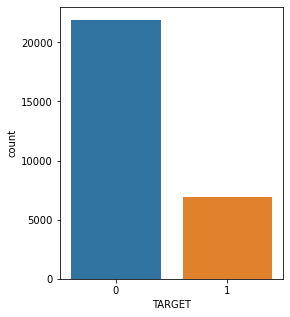

In [5]:
plt.figure(figsize=(4, 5))
sns.countplot(y)
plt.show()

## 3. 데이터 전처리

### 학습-평가 데이터셋 구성
- Train:Test = 80:20
- 클래스 비율 유지: train_test_split 함수 내 stratify 옵션
- randomstate = 2020

In [6]:
random_state = 2020
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=2/10, random_state=random_state, stratify=y)

#### 데이터 스케일링: 0-1

In [7]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 4. 최적 파라미터 탐색: Grid Search

#### parameter grid 지정
- dictioanry 안의 list 형태로 넣어서 구성

In [8]:
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['cosine', 'euclidean', 'manhattan']
}

#### 기본 모델 구성 (grid search 외에 고정할 파라미터를 설정할 수 있음)

In [9]:
model = KNeighborsClassifier()

#### Grid Search CV 모델 구성: cv = 5

In [10]:
SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [11]:
model_cv = GridSearchCV(estimator=model,
                        param_grid=param_grid,
                        cv=5,verbose=1,
                        n_jobs=-1)
model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.4min finished


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['cosine', 'euclidean', 'manhattan'],
                         'n_neighbors': [1, 3, 5, 7, 9, 11],
                         'weights': ['uniform', 'distance']},
             verbose=1)

### 필요한 정보 추출
- 파라미터 조합 이름
- 5-CV 성능의 평균 및 표준편차

In [12]:
results = model_cv.cv_results_
params = results['params']
mean_score = results['mean_test_score']
std_score =results['std_test_score']

In [13]:
params = ['_'.join(str(x) for x in param.values()) for param in params]
params[:5]

['cosine_1_uniform',
 'cosine_1_distance',
 'cosine_3_uniform',
 'cosine_3_distance',
 'cosine_5_uniform']

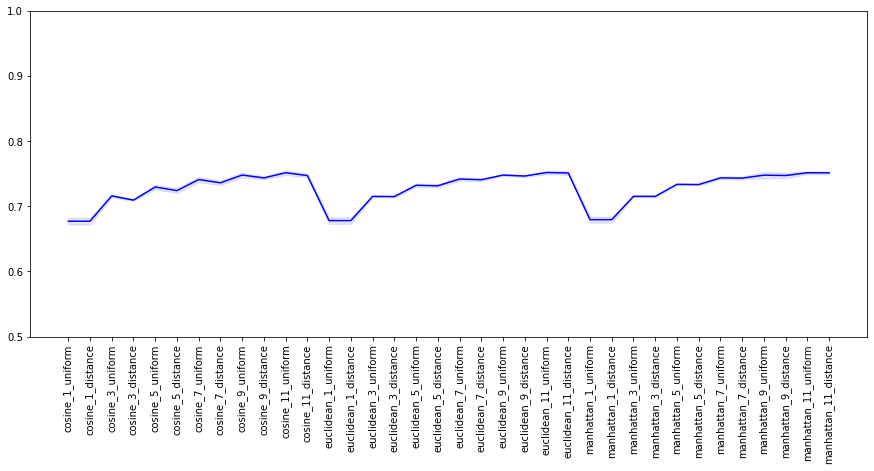

In [14]:
plt.figure(figsize=(15, 6))
plt.fill_between(range(len(params)), mean_score - std_score, mean_score + std_score, alpha=0.1, color='blue')
plt.plot(range(len(params)), mean_score, color='blue')
plt.ylim([0.5, 1.0])
plt.xticks(range(len(params)), params, rotation=90)
plt.show()

#### Best Parameter 찾기

In [15]:
print('Best parameters (Grid Search) \n >> ', model_cv.best_params_)

Best parameters (Grid Search) 
 >>  {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'uniform'}


#### Best Model 찾기
1) best parameter를 사용해서 모델을 다시 학습  
2) best_estimator_를 그대로 사용

In [16]:
model = model_cv.best_estimator_
model

KNeighborsClassifier(metric='euclidean', n_neighbors=11)

#### 모델 평가 (test)

In [17]:
# 에측 결과 산출
y_test_pred = model.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
cm = pd.DataFrame(cm)

# Accuracy, F1-Score
acc = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print('- Accuracy (Test) : {:.3}'.format(acc))
print('- F1 score (Test) : {:.3}'.format(f1))

- Accuracy (Test) : 0.752
- F1 score (Test) : 0.247


#### 정오행렬 시각화

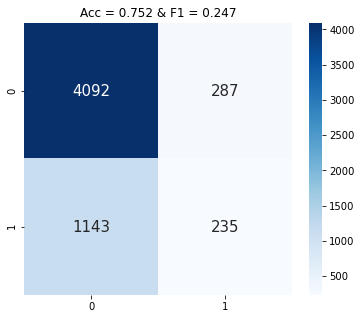

In [18]:
# 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(data=cm, annot=True, annot_kws={'size': 15}, fmt='d', cmap='Blues')
plt.title('Acc = {:.3f} & F1 = {:.3f}'.format(acc, f1))
plt.show()

#y축이 실제 값 x축이 예상한 값

## 5. 클래스 불균형: F1-Score를 사용해서 다시 한번!

#### Grid Search

In [19]:
model_cv = GridSearchCV(estimator=model,
                        param_grid=param_grid,
                        scoring='f1',
                        cv=5,
                        n_jobs=-1)
model_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=KNeighborsClassifier(metric='euclidean', n_neighbors=11),
             n_jobs=-1,
             param_grid={'metric': ['cosine', 'euclidean', 'manhattan'],
                         'n_neighbors': [1, 3, 5, 7, 9, 11],
                         'weights': ['uniform', 'distance']},
             scoring='f1')

In [20]:
print('Best parameters (Grid Search) \n >> ', model_cv.best_params_)

Best parameters (Grid Search) 
 >>  {'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}


#### Best Model 선정

In [21]:
model = model_cv.best_estimator_
model

KNeighborsClassifier(metric='manhattan', n_neighbors=1)

#### 모델 평가 (test)

In [22]:
# 에측 결과 산출
y_test_pred = model.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
cm = pd.DataFrame(cm)

# Accuracy, F1-Score
acc = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print('- Accuracy (Test) : {:.3}'.format(acc))
print('- F1 score (Test) : {:.3}'.format(f1))

- Accuracy (Test) : 0.67
- F1 score (Test) : 0.317


#### 정오행렬 시각화

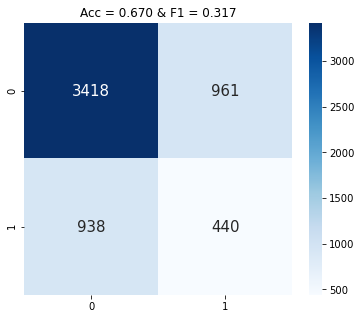

In [23]:
# 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(data=cm, annot=True, annot_kws={'size': 15}, fmt='d', cmap='Blues')
plt.title('Acc = {:.3f} & F1 = {:.3f}'.format(acc, f1))
plt.show()

In [24]:
results = model_cv.cv_results_
params = results['params']
mean_score = results['mean_test_score']
std_score =results['std_test_score']

In [25]:
params = ['_'.join(str(x) for x in param.values()) for param in params]
params[:5]

['cosine_1_uniform',
 'cosine_1_distance',
 'cosine_3_uniform',
 'cosine_3_distance',
 'cosine_5_uniform']

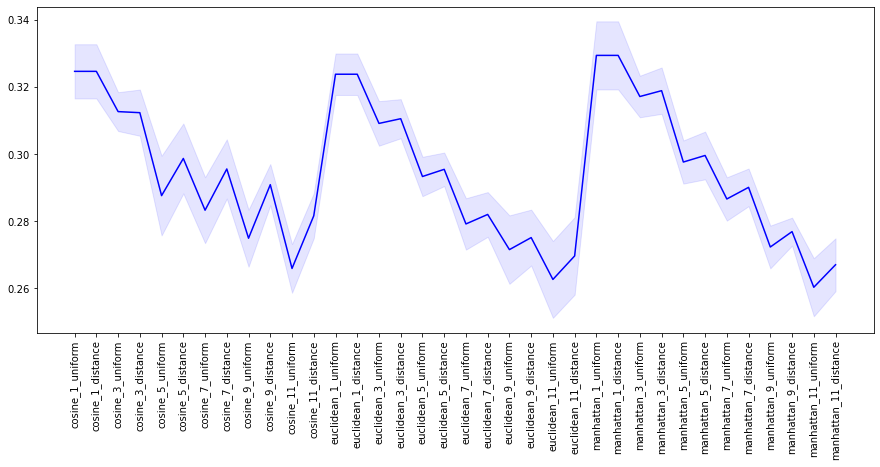

In [27]:
plt.figure(figsize=(15, 6))
plt.fill_between(range(len(params)), mean_score - std_score, mean_score + std_score, alpha=0.1, color='blue')
plt.plot(range(len(params)), mean_score, color='blue')
# plt.ylim([0.5, 1.0])
plt.xticks(range(len(params)), params, rotation=90)
plt.show()